In [11]:
import xarray as xr
import xesmf as xe
import numpy as np 
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from metpy.calc import relative_humidity_from_mixing_ratio, mixing_ratio_from_relative_humidity
import metpy.calc as mpcalc
from metpy.units import units


In [12]:
def get_wrf_precip(WY, 
                   base,
                   mlist=["10","11","12", "01", "02", "03", "04"]):
    
    listofwrf = [base.joinpath("WY%s/Month%s_SfcMet_wsub_WY%s.nc"%(WY,x,WY)) for x in mlist]

    good_files = [phile.is_file() for phile in listofwrf]
    if False in good_files:
        print(good_files, "missing files")
        return None, None

    ds=xr.open_mfdataset(listofwrf, combine='nested', concat_dim='XTIME', parallel=True)
    return ds

mp08_run = pl.Path("/scratch/wrudisill/EastLSM_Only/WRF_subset_files/Thompson")
mp10_run = pl.Path("/scratch/wrudisill/EastLSM_Only/WRF_subset_files/Morrison")
mp55_run = pl.Path("/scratch/wrudisill/EastLSM_Only/WRF_subset_files/Ishmael")    



In [13]:
mp08_2018 = get_wrf_precip(2018, mp08_run)
mp08_2019 = get_wrf_precip(2019, mp08_run)

mp10_2018 = get_wrf_precip(2018, mp10_run)
mp10_2019 = get_wrf_precip(2019, mp10_run)

mp55_2018 = get_wrf_precip(2018, mp55_run)
mp55_2019 = get_wrf_precip(2019, mp55_run)



In [14]:
ds = xr.open_dataset("/scratch/wrudisill/EastLSM_Only/geo_em.d02.nc")

In [15]:
# Do the spatial subsetting here...
west_lon = -107.2  # decreasing to the west...
east_lon = -106.22  # increasing to the east...
north_lat = 39.15
south_lat = 38.49


subregion = ds.where((west_lon < ds.XLONG_M) & (ds.XLONG_M < east_lon)
& (south_lat < ds.XLAT_M) & (ds.XLAT_M < north_lat ), drop=True)

In [16]:
subregion.HGT_M

<xarray.DataArray 'HGT_M' (Time: 1, south_north: 74, west_east: 85)>
array([[[2473.0923, 2436.703 , 2442.3306, ..., 3466.645 , 3276.8188,
         3134.965 ],
        [2543.1875, 2509.802 , 2502.4912, ..., 3418.4978, 3310.0547,
         3151.6465],
        [2597.439 , 2577.8452, 2547.1628, ..., 3376.87  , 3301.6748,
         3169.1448],
        ...,
        [3206.5986, 3394.292 , 3588.1858, ..., 3260.4531, 3314.0674,
         3446.4573],
        [3295.3496, 3515.8472, 3621.9353, ..., 3318.0527, 3397.6074,
         3543.611 ],
        [3335.1035, 3538.125 , 3560.1113, ..., 3289.361 , 3409.8865,
         3581.9688]]], dtype=float32)
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        meters MSL
    description:  GMTED2010 30-arc-second topography height
    stagger:      M
    sr_x:         1
    sr_y:         1

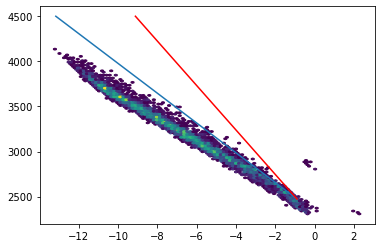

In [17]:
fig,ax=plt.subplots(1)

temp_avg = mp10_2019.T2.mean(dim="XTIME").values.flatten() - 273.15
height   = subregion.HGT_M.values.flatten()

ax.hexbin(temp_avg,
          height, 
          mincnt=1)

# the adiabatic lapse rate 
ax.plot([temp_avg[0], -.0065*(4500 - height[0])],  [height[0], 4500])
ax.plot([temp_avg[0], -.0045*(4500 - height[0])],  [height[0], 4500], color='red')


In [18]:
6.5/1000

0.0065

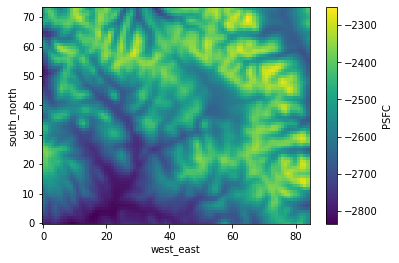

In [28]:
((mp10_2018.PSFC * np.exp(-300/8000)).mean(dim="XTIME") - mp10_2018.PSFC.mean(dim="XTIME")).plot()

In [33]:
np.exp(-1*-10/8000)

1.0012507815756226

In [9]:
rh = relative_humidity_from_mixing_ratio(mp10_2018.PSFC * units("Pa"), 
                                         mp10_2018.T2 * units("kelvin"), 
                                         mp10_2018.Q2 * units("kg/kg") )

# ok... now get the mixing ratio from the relative humidity given the updated temperatures ....
mixing_ratio_from_relative_humidity


<function metpy.calc.thermo.mixing_ratio_from_relative_humidity(pressure, temperature, relative_humidity)>

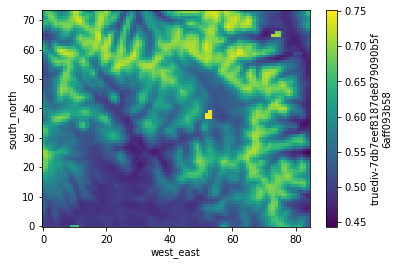

In [10]:
rh.mean(dim="XTIME").plot()

In [16]:
mp10_2018.T2 * units("kelvin")

<xarray.DataArray 'T2' (XTIME: 5088, south_north: 74, west_east: 85)>
<Quantity(dask.array<mul, shape=(5088, 74, 85), dtype=float32, chunksize=(744, 74, 85), chunktype=numpy.ndarray>, 'kelvin')>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(74, 85), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(74, 85), meta=np.ndarray>
  * XTIME    (XTIME) datetime64[ns] 2017-10-01 ... 2018-04-30T23:00:00
Dimensions without coordinates: south_north, west_east

In [35]:
mp10_2018.T2.values

array([[[285.92734, 286.4359 , 286.5264 , ..., 274.32117, 274.32672,
         278.28876],
        [284.79593, 285.34134, 285.5529 , ..., 276.48157, 277.09738,
         277.99084],
        [284.33072, 284.56134, 284.92065, ..., 276.63635, 276.7449 ,
         278.23117],
        ...,
        [276.92343, 275.1639 , 273.39288, ..., 275.26917, 274.8855 ,
         274.07086],
        [276.33264, 274.29337, 273.3943 , ..., 274.96106, 274.47955,
         273.68735],
        [275.98947, 274.034  , 273.50757, ..., 275.04047, 274.37524,
         273.44888]],

       [[283.21008, 283.67566, 283.6988 , ..., 275.78857, 277.09586,
         276.95013],
        [282.35904, 282.86066, 282.9944 , ..., 276.22455, 276.92575,
         275.70282],
        [281.9376 , 282.12357, 282.41245, ..., 275.0889 , 275.10956,
         275.07785],
        ...,
        [275.06372, 273.48618, 272.6928 , ..., 275.68756, 275.19147,
         274.06146],
        [274.53378, 273.2176 , 272.65717, ..., 275.28802, 274.675  ,
   